# Set up Libraries / GPU Check

In [1]:
######################################################Initial Packages########################################################
#Basic Operating System Stuff
import os, gc, random

#Basic dataframe, array, and math stuff
import pandas as pd #data frame
import math #math functions
import numpy as np    #numerical package

#Scikit learn
import sklearn as sk  #scikit learn
from sklearn import metrics
from sklearn.model_selection import train_test_split as tts #train test split
from sklearn.metrics import confusion_matrix, roc_curve, classification_report #for 2-class model
from sklearn.preprocessing import MinMaxScaler as MMS

#Tensorflow
import tensorflow as tf 
from tensorflow.python.client import device_lib #GPU Check
import tensorflow.keras #keras
from tensorflow.keras import layers 
from tensorflow.keras import Sequential,Input,Model 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Add, Activation, ZeroPadding2D,GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization,Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, LeakyReLU  
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint #use for early stopping and reduction on level-out
from tensorflow.keras.initializers import glorot_uniform, he_uniform #to initialize random weights for filters
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions, preprocess_input
from tensorflow.keras.models import Model, load_model  #Can't do much without a model
from tensorflow.keras import utils
from tensorflow.keras.utils import get_file, plot_model, to_categorical, model_to_dot
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50V2, MobileNetV2, VGG16 
import tensorflow.keras.backend as K #let's write our own metrics and loss functions

#Graphing
import cv2
from PIL import Image
import glob           #helps read files
import matplotlib.pyplot as plt

print(device_lib.list_local_devices()) #Let's see if Python recognizes my GPU, shall we?
################################################conda ##############################################################################

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11004929504340646631
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9082497722870691570
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6918604064
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1790778523248432859
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Super, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4358477848498878101
physical_device_desc: "device: XLA_GPU device"
]


# GPU / Memory Management

In [2]:
#Define function for clearing GPU memory
def reset_keras():
    tensorflow.keras.backend.clear_session
    gc.collect()
reset_keras()

# Read Data

## Read Function for Training Data

random.seed(1234) #set the random seed
images,labels=[], []  #storage for images and labels from the tensorflow files
features = {'label': tf.io.FixedLenFeature([], tf.int64),'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)}

#Read the data

def readFile(files):
    mydata = tf.data.TFRecordDataset(files,num_parallel_reads=4).shuffle(buffer_size=10000).cache()
    mydata = mydata.map(lambda x: tf.io.parse_example(x, features), num_parallel_calls=4)
    for image_features in mydata:
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])
        image=np.asarray(image)
        images.append(image)
        labels.append(image_features['label'].numpy())

## Read Training Data from Tensors

reset_keras()
files=['D:/breast/training10_0/training10_0.tfrecords',
       'D:/breast/training10_1/training10_1.tfrecords',
       'D:/breast/training10_2/training10_2.tfrecords',
       'D:/breast/training10_3/training10_3.tfrecords',
       'D:/breast/training10_4/training10_4.tfrecords']
#load the data
for file in files:
    readFile(file)  

## Train Images & Labels

#Save the data
x=0
for image in images:
    tmp='d:/breast/train/'
    tmp+=str(x)
    tmp+='.jpg'
    plt.imsave(tmp,image)
    x+=1
np.savetxt('d:/breast/train/labels.csv', labels,delimiter=",")

# Build Training DataFrame

In [3]:
#set up labels
y_train=np.loadtxt('d:/breast/train/labels.csv', delimiter=",").astype('int')
y_train=np.where(y_train==0, 0, y_train)
y_train=np.where(y_train!=0, 1, y_train)
print(np.bincount(y_train)/len(y_train))
y_train=y_train.astype('str') #for tensorflow

#Load Files
myf=glob.glob("D:/breast/train/*.jpg")
mysplit=[]
for files in myf:
    tmp=files.split('\\')
    tmp=tmp[1].split('.')
    tmp=int(tmp[0])
    mysplit.append(tmp)

d = {'file': myf, 'number': mysplit}
traindf=pd.DataFrame(d)
traindf=traindf.sort_values(by=['number']) #sort BEFORE you add the other variable
traindf['label']=y_train
print(traindf.iloc[0:10,:])
print(traindf.dtypes)

[0.86957144 0.13042856]
                        file  number label
0      D:/breast/train\0.jpg       0     0
1      D:/breast/train\1.jpg       1     0
11112  D:/breast/train\2.jpg       2     0
22223  D:/breast/train\3.jpg       3     1
33334  D:/breast/train\4.jpg       4     0
44445  D:/breast/train\5.jpg       5     0
51441  D:/breast/train\6.jpg       6     1
52552  D:/breast/train\7.jpg       7     0
53663  D:/breast/train\8.jpg       8     0
54774  D:/breast/train\9.jpg       9     1
file      object
number     int64
label     object
dtype: object


## Read Test

x_test=np.concatenate((np.load("d:/breast/cv10_data/cv10_data.npy"),np.load("d:/breast/test10_data/test10_data.npy")))
y_test=np.concatenate((np.load("d:/breast/cv10_labels.npy"),np.load("d:/breast/test10_labels.npy")))                      
y_test=np.where(y_test==0, 0, y_test)
y_test=np.where(y_test!=0, 1, y_test)

## Test Images & Labels

x=0
for i in range(x_test.shape[0]):
    tmp='d:/breast/test/'
    tmp+=str(x)
    tmp+='.jpg'
    plt.imsave(tmp,x_test[i,:,:,0])
    x+=1
 np.savetxt('d:/breast/test/y_test.csv', y_test,delimiter=",")

# Build Test Dataframe

In [4]:
#set up labels
y_test=np.loadtxt('d:/breast/test/y_test.csv', delimiter=","). astype('int')
print(np.bincount(y_test)/len(y_test))
y_test=y_test.astype('str') #for tensorflow

myf2=glob.glob("D:/breast/test/*.jpg")  
mysplit=[]
for files in myf2:
    tmp=files.split('\\')
    tmp=tmp[1].split('.')
    tmp=int(tmp[0])
    mysplit.append(tmp)
d = {'file': myf2, 'number': mysplit}
testdf=pd.DataFrame(d)
testdf=testdf.sort_values(by=['number']) #sort BEFORE you add the other variable
testdf['label']=y_test
print(testdf.iloc[0:10,:])

[0.86956522 0.13043478]
                       file  number label
0      D:/breast/test\0.jpg       0     0
1      D:/breast/test\1.jpg       1     0
6476   D:/breast/test\2.jpg       2     1
7587   D:/breast/test\3.jpg       3     0
8698   D:/breast/test\4.jpg       4     0
9809   D:/breast/test\5.jpg       5     0
10920  D:/breast/test\6.jpg       6     0
12031  D:/breast/test\7.jpg       7     0
13142  D:/breast/test\8.jpg       8     0
14253  D:/breast/test\9.jpg       9     0


# Plot Some Images

10

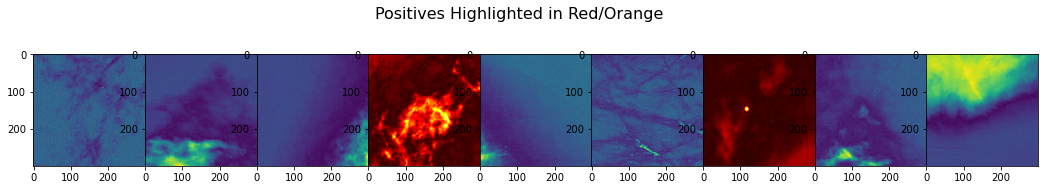

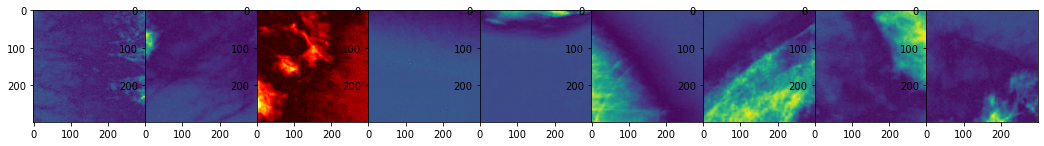

In [5]:
reset_keras() #clear memory
fig, ax = plt.subplots(1,9, figsize=[18, 3])  #set first figure
fig2, ax2 = plt.subplots(1,9, figsize=[18, 3]) #set second figure
fig.suptitle('Positives Highlighted in Red/Orange', fontsize=16)
for i in range(9):
    tmp=plt.imread(traindf.iloc[i,0])
    tmp=tmp[:,:,0]
    tmp2=y_train[i].astype('int')
    ax[i].imshow(tmp) if tmp2==0 else ax[i].imshow(tmp,cmap='hot') 
    fig.subplots_adjust(wspace=0, hspace=0)
for i in range(9):
    tmp=plt.imread(testdf.iloc[i,0])
    tmp=tmp[:,:,0]
    tmp2=y_test[i].astype('int')    
    ax2[i].imshow(tmp) if tmp2==0 else ax2[i].imshow(tmp,'hot') 
    fig2.subplots_adjust(wspace=0, hspace=0)
gc.collect()

## Autoencoder-Backup

from tensorflow.keras.optimizers import Adam
gc.collect()
reset_keras()
size=96

#build a sequential autoencoder as a neural network

autoencoder = Sequential()
autoencoder.add(Dense(size,  activation='elu',input_shape=(size,size)))
autoencoder.add(Dense(int(size/1.5),  activation='elu'))
autoencoder.add(Dense(int(size/2),  activation='elu'))
autoencoder.add(Dense(int(size/4),  activation='elu'))
autoencoder.add(Dense(int(size/6),    activation='linear', name="bottleneck"))
autoencoder.add(Dense(int(size/4),  activation='elu'))
autoencoder.add(Dense(int(size/2),  activation='elu'))
autoencoder.add(Dense(int(size/1.5),  activation='elu'))
autoencoder.add(Dense(size,  activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())
trained_model = autoencoder.fit(x_train, x_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_test,x_test))

#build the encoder model
encoder=Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)

#encode the data
encoded_data = encoder.predict(x_train)  # bottleneck representation    

#cleaned data
cleaned_data = autoencoder.predict(x_train)




#reconstruct the data
decoded_output = autoencoder.predict(x_train)  
encoding_dim = 16
encoded_input = Input(shape=(encoding_dim,))

decoder = autoencoder.layers[-4](encoded_input)
decoder = autoencoder.layers[-3](decoder)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)


# Flow from DataFrame

In [10]:
random.seed(1234)
batch_size=32
size=299
acc=[]      #array for storing validation accuracy
loss=[]     #array for storing validation loss
tngacc=[]   #array for storing training accuracy
tngloss=[]
myscaler=MMS()



with tf.device('/GPU:0'):

        aug=ImageDataGenerator(rescale=1./255)
                                 #samplewise_center=True,
                                 #samplewise_std_normalization=True,
                                 #rotation_range=10, 
                                 #zoom_range=0.2, 
                                 #width_shift_range=0.1, 
                                 #height_shift_range=0.1, 
                                 #shear_range=.1,
                                 #horizontal_flip=True,
                                 #fill_mode="nearest")#, 
                                 #validation_split=.2)
      
        
        train_generator=aug.flow_from_dataframe(
                                 dataframe=traindf, 
                                 directory=None,                           
                                 x_col="file", 
                                 y_col="label", 
                                 class_mode="binary", 
                                 color_mode='rgb',
                                 target_size=(size,size), 
                                 shuffle=True,
                                 batch_size=batch_size, subset='training')
        
        #validation_generator=aug.flow_from_dataframe(
                #                 dataframe=traindf, 
                #                 directory=None,                           
                #                 x_col="file", 
                #                 y_col="label", 
                #                 class_mode="binary", 
                #                 color_mode='rgb',
                #                 target_size=(size,size), 
                #                 shuffle=False,
                #                 batch_size=batch_size, subset='validation')
        
        test_datagen = ImageDataGenerator(rescale=1./255)
        
        test_generator = test_datagen.flow_from_dataframe(
                                 testdf, 
                                 x_col="file", 
                                 y_col="label", 
                                 class_mode="binary",
                                 color_mode='rgb',
                                 target_size=(size,size),
                                 batch_size=batch_size,
                                 shuffle=False)
##############################################################################################################################

Found 55885 validated image filenames belonging to 2 classes.
Found 15364 validated image filenames belonging to 2 classes.


# Build and Run Models

## Build Model

In [11]:
#Begin with a typical VGG16
myconv = VGG16(weights='imagenet', include_top=False, input_shape = (size,size, 3))

#Potentially fix layers.  I don't.
#for layer in myconv.layers[:-8]:
#    layer.trainable = False

#Build the rest of the model
x = myconv.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation="sigmoid", name='classifier')(x)
model=Model(myconv.input, x)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)      

## Run Model

In [12]:
reset_keras()
gc.collect()
numepochs=50 #may stop and re-run...10
step_size=train_generator.n//train_generator.batch_size
#model.load_weights('d:/breast/best_model.hdf5')
early = EarlyStopping(monitor='val_loss', mode='min', patience=3,restore_best_weights=True, verbose=2)
checkpoint = ModelCheckpoint("D:/breast/best_model.hdf5", monitor='accuracy', verbose=2,
    save_best_only=True, mode='auto')

with tf.device('/GPU:0'):  #Use the GPU
    model.compile(optimizer='adagrad',loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(train_generator, steps_per_epoch=step_size, epochs=numepochs, callbacks=[checkpoint, early], 
                       validation_data=test_generator)  
    
acc.append(history.history['val_accuracy']) #append validation accuracy
loss.append(history.history['val_loss']) #append validation loss
tngacc.append(history.history['accuracy']) #append training accuracy
tngloss.append(history.history['loss']) #append training loss
    

Epoch 1/50
1746/1746 [==============================] - ETA: 0s - loss: 0.3042 - accuracy: 0.8762
Epoch 00001: accuracy improved from -inf to 0.87617, saving model to D:/breast\best_model.hdf5
1746/1746 [==============================] - 879s 503ms/step - loss: 0.3042 - accuracy: 0.8762 - val_loss: 0.2583 - val_accuracy: 0.9002
Epoch 2/50
1746/1746 [==============================] - ETA: 0s - loss: 0.2305 - accuracy: 0.9059
Epoch 00002: accuracy improved from 0.87617 to 0.90590, saving model to D:/breast\best_model.hdf5
1746/1746 [==============================] - 978s 560ms/step - loss: 0.2305 - accuracy: 0.9059 - val_loss: 0.1916 - val_accuracy: 0.9234
Epoch 3/50
1746/1746 [==============================] - ETA: 0s - loss: 0.1857 - accuracy: 0.9279
Epoch 00003: accuracy improved from 0.90590 to 0.92790, saving model to D:/breast\best_model.hdf5
1746/1746 [==============================] - 939s 538ms/step - loss: 0.1857 - accuracy: 0.9279 - val_loss: 0.1617 - val_accuracy: 0.9395
Epoc

In [13]:
test_generator.reset()
pred=model.predict(test_generator,verbose=1)

481/481 [==============================] - 61s 127ms/step


## Plot

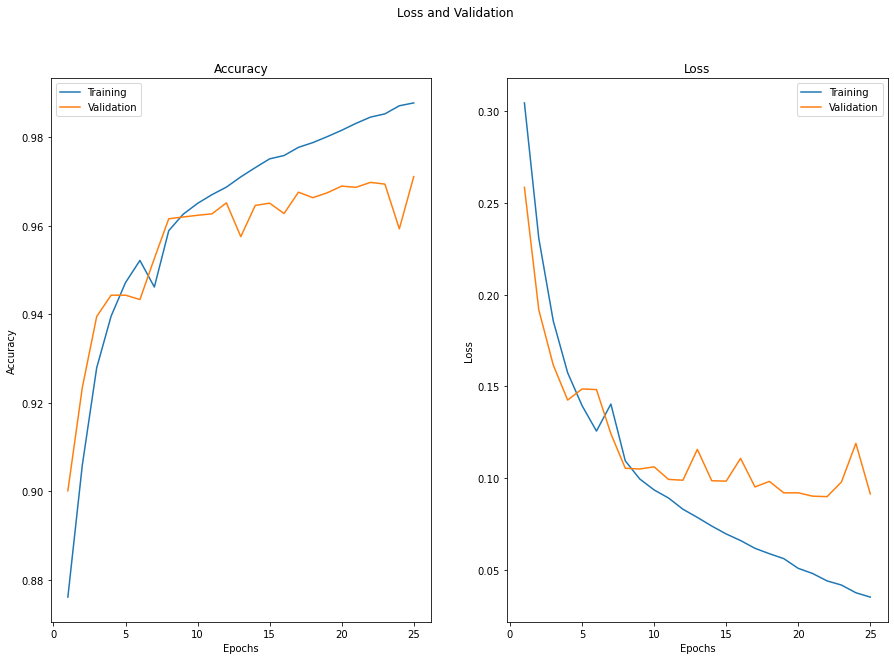

In [64]:
reset_keras()
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle("Loss and Validation")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Training', 'Validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['Training', 'Validation'])
    plt.show()
    

Train_Val_Plot(np.hstack(tngacc),np.hstack(acc), np.hstack(tngloss),np.hstack(loss))

# Metrics

In [65]:
pred=np.hstack(np.round(pred,0))
act=y_test.astype('int')
target=["Negative","Positive"] 
cm=metrics.confusion_matrix(act, pred)
print(cm)
print('Accuracy:', np.round(metrics.accuracy_score(act, pred),3))
print('F1 Score:', np.round(metrics.f1_score(act, pred),3))
print('Specificity', np.round(cm[0,0]/(cm[0,0]+cm[0,1]),3))
print(metrics.classification_report(act, pred,target_names=target))

[[13229   131]
 [  334  1670]]
Accuracy: 0.97
F1 Score: 0.878
Specificity 0.99
              precision    recall  f1-score   support

    Negative       0.98      0.99      0.98     13360
    Positive       0.93      0.83      0.88      2004

    accuracy                           0.97     15364
   macro avg       0.95      0.91      0.93     15364
weighted avg       0.97      0.97      0.97     15364



In [72]:
import scipy as sp
gc.collect()
reset_keras()

partial=[]
pos=[2, 13, 25, 26, 38, 42, 44, 61, 62, 76, 79, 88, 93, 99]
for i in range(len(pos)):
    temp=plt.imread(traindf.iloc[i,0])
    partial.append(temp)

partial=np.asarray(partial)
partial

array([[[[ 68,  44, 120],
         [ 70,  46, 122],
         [ 73,  51, 126],
         ...,
         [ 69,  45, 123],
         [ 71,  42, 122],
         [ 72,  39, 120]],

        [[ 70,  49, 124],
         [ 69,  51, 125],
         [ 71,  55, 128],
         ...,
         [ 67,  43, 121],
         [ 69,  40, 120],
         [ 71,  38, 119]],

        [[ 68,  56, 128],
         [ 68,  58, 129],
         [ 68,  61, 131],
         ...,
         [ 69,  42, 121],
         [ 71,  40, 120],
         [ 71,  38, 119]],

        ...,

        [[ 73,  49, 127],
         [ 72,  48, 126],
         [ 73,  52, 129],
         ...,
         [ 67,  19, 103],
         [ 67,  20, 101],
         [ 68,  19, 101]],

        [[ 74,  50, 128],
         [ 71,  48, 126],
         [ 70,  52, 128],
         ...,
         [ 71,  26, 109],
         [ 73,  26, 107],
         [ 73,  26, 107]],

        [[ 75,  52, 130],
         [ 71,  50, 127],
         [ 68,  52, 127],
         ...,
         [ 74,  31, 113],
        

# Function to Paint Anomalies based on Single Layer

In [93]:
import scipy as sp
gc.collect()
reset_keras()

intermediate = Model(model.input,model.get_layer("block5_conv3").output) #get bottom layer and use as model
conv_output = intermediate.predict(partial)   #get the testing output
conv_output = np.squeeze(conv_output) #Remove unnecessary layer
weights = np.squeeze(model.layers[-1].get_weights()[0])  #get the weights

def myplot(img):    
    conv_output2 = conv_output[img] #get the prediction
    #r = int(size/conv_output2.shape[0]) #multiplying ratio for mapping
    r=299/18
    act_maps = sp.ndimage.zoom(conv_output2, (r,r, 1), order=1)
    act_maps=act_maps.reshape((size*size,intermediate.output.shape[3]))
    out = act_maps@weights
    out=out
    out=out.reshape(size,size)/255
    return(out)

# View Features from One Layer

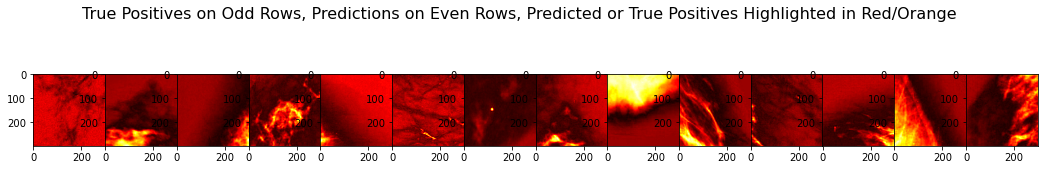

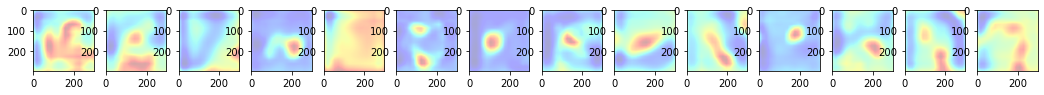

In [94]:
numim=14
   
fig, ax = plt.subplots(1,numim, figsize=[18, 3])
fig2, ax2 = plt.subplots(1,numim, figsize=[18, 3])
fig.suptitle('True Positives on Odd Rows, Predictions on Even Rows, Predicted or True Positives Highlighted in Red/Orange', fontsize=16)

zeros=np.zeros((size,size))

x=0
for i in partial:
    val=y_test[i]
    ax[x].imshow(partial[x, :,:,0],'hot') 
    fig.subplots_adjust(wspace=0, hspace=0)
    x+=1
x=0
for i in partial:
    val=y_test[i]
    temp=myplot(x)
    #temp=myscaler.fit_transform(temp)
    ax2[x].imshow(temp, 'jet', alpha=.35)
    fig.subplots_adjust(wspace=0, hspace=0)
    x+=1
    

         

# Paint Convolutional Layer Images

layer_names = [layer.name for layer in model.layers] #get the names
u=18 #number of layers I will select
layer_names = [layer.name for layer in model.layers[1:u]] #get the names
layer_outputs = [layer.output for layer in model.layers[1:u]] #get the outputs
print(layer_names)

# Get Important Layer Outputs

feature_map_model = Model(model.input, layer_outputs) #build the models
feature_maps = feature_map_model.predict(partial) #predict the features

# Get the Images into an Array

image_belt=[]
for layer_name, feature_map in zip(layer_names, feature_maps):  
    for i in range(numim):
        feature_image = feature_map[i, :, :, 0]
        h = int(size/feature_image.shape[0]) #multiplying ratios for mapping
        feature_image = sp.ndimage.zoom(feature_image, (h, h), order=1)
        feature_image=feature_image/255
        image_belt.append(feature_image)
image_belt=np.asarray(image_belt)
print(image_belt.shape)


# Paint the Layer Representation (Not Used)

im=7 #number of images per line
imnum=0 #17 layers, 0 to 16....image 0 starts at 0 ends at 16; image 1 starts at 17, image 2 starts at 30
begin=imnum*17-17

fig, ax = plt.subplots(1,im, figsize=[18, 3])
fig2, ax2 = plt.subplots(1,im, figsize=[18, 3])
fig3, ax3 = plt.subplots(1,im, figsize=[18, 3])

ax[0].imshow(x_test[imnum, :,:,0],cmap='hot') 
ax[0].set_title('Original')
for i in np.arange(1,im):
    ax[i].imshow(image_belt[begin-1+i],cmap='hot')   #map for 6 other layers
    t=['Layer ',i]
    ax[i].set_title(t)
for i in np.arange(0,im):
    ax2[i].imshow(image_belt[begin+i],cmap='hot')  #map for 
    t=['Layer ',i+7]
    ax2[i].set_title(t)
for i in np.arange(0,im):
    ax3[i].imshow(image_belt[begin+i],cmap='hot')
    t=['Layer ',i+14]
    ax3[i].set_title(t)


## Get the Gradient of the Score with respect to the Image Layer

In [97]:
#@tf.RegisterGradient("GuidedRelu")
#def _GuidedReluGrad(op, grad):
#   gate_f = tf.cast(op.outputs[0] > 0, "float32") #for f^l > 0
#   gate_R = tf.cast(grad > 0, "float32") #for R^l+1 > 0
#   return gate_f * gate_R * grad

def watch_layer(layer, tape):
    def decorator(func):
        def wrapper(*args, **kwargs):
            # Store the result of `layer.call` internally.
            layer.result = func(*args, **kwargs)
            # From this point onwards, watch this tensor.
            tape.watch(layer.result)
            # Return the result to continue with the forward pass.
            return layer.result
        return wrapper
    layer.call = decorator(layer.call)
    return layer

bx = tf.reshape(partial[0, :, :, :], (1, size,size, 3))
last_conv_layer = model.get_layer('block5_conv3')
with tf.compat.v1.get_default_graph().gradient_override_map({'Relu': 'GuidedRelu'}):
    with tf.GradientTape() as gtape:
        watch_layer(last_conv_layer, gtape)  
        preds = model(partial)
        grads=gtape.gradient(preds, last_conv_layer.result)

# Get the gradient w.r.t. the output of `last_conv_layer`
grads.shape


TensorShape([14, 18, 18, 512])

## Get the Neuron Activations

In [98]:
myneurons=conv_output
plotnum=pos
rank=myneurons

# Plot Function

In [100]:
final=[]
x=[]
y=[]
ct=0
for plots in plotnum:
    conv_output2=conv_output[0]
    r = 299/18
    tmp=sp.ndimage.zoom(myneurons[ct], (r,r, 1), order=1)
    tmp.shape
    tmp=tmp.reshape((size*size,512))
    tmp=tmp@weights
    tmp=tmp.reshape(size,size)
    tmp=myscaler.fit_transform(tmp)
    #tmp=abs(tmp)
    final.append(tmp)    
    t1=np.argmax(np.max(tmp, axis=0))
    x.append(t1)
    t2=np.argmax(np.max(tmp, axis=1))
    y.append(t2)
    ct+=1


# Plot and Identify Activation Area

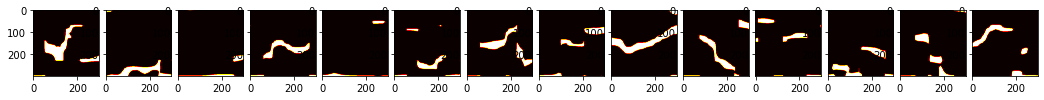

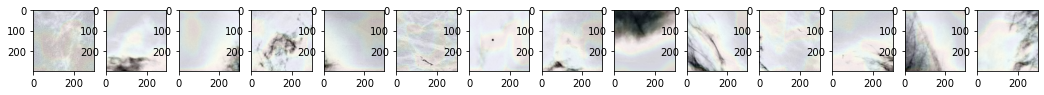

In [118]:
from matplotlib.patches import Circle

fig, ax = plt.subplots(1,14, figsize=[18, 3])
fig1,ax1=plt.subplots(1,14, figsize=[18, 3])



for i in range(14):
    mask=np.zeros((size,size))
    mask[final[i]>np.quantile(final[0],.9)]=1
    ax[i].imshow(mask, cmap='hot') 
for i in range(14):
    mask=np.zeros((size,size))
    #mask[final[i]>np.quantile(final[0],.9)]=1
    ax1[i].imshow(partial[i,:,:,0], cmap='Greys') 
    ax1[i].imshow(final[i], cmap='jet', alpha=.05)
    
fig.subplots_adjust(wspace=.1, hspace=.1)

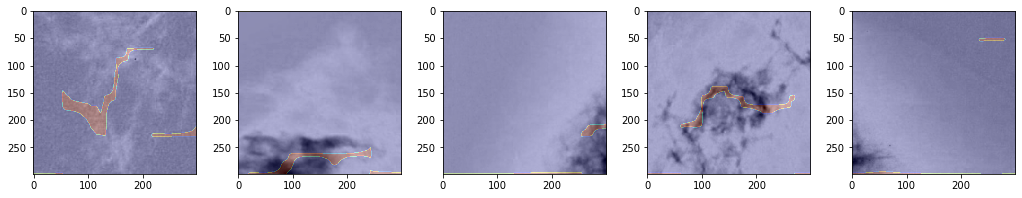

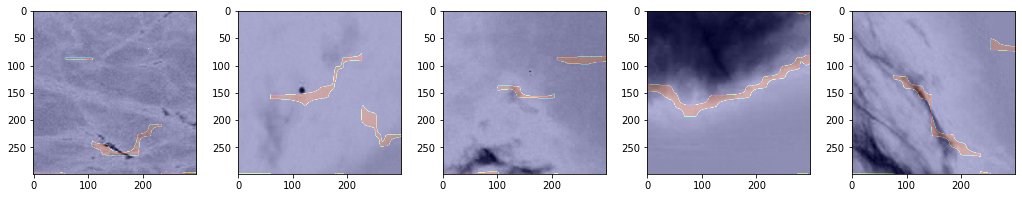

In [140]:
from matplotlib.patches import Circle

fig, ax = plt.subplots(1,5, figsize=[18, 3])
fig1,ax1=plt.subplots(1,5, figsize=[18, 3])


for i in range(5):
    mask=np.zeros((size,size))
    mask[final[i]>np.quantile(final[0],.95)]=1
    ax[i].imshow(partial[i,:,:,0], cmap='binary') 
    ax[i].imshow(mask, cmap='jet', alpha=.3) 
    fig.subplots_adjust(wspace=.1, hspace=.1)
for i in range(5):
    mask=np.zeros((size,size))
    mask[final[i+5]>np.quantile(final[0],.95)]=1
    ax1[i].imshow(partial[i+5,:,:,0], cmap='binary') 
    ax1[i].imshow(mask, cmap='jet', alpha=.3) 
    fig1.subplots_adjust(wspace=.1, hspace=.1)